# Quiz 2 - Image Processing

**Eugenio Pacceli**

**Renato Oliveira**

**Brian Acevedo**

First task consisted of creating three masks with shapes (3x3), (5x5) and (7x7) based on Butterworth filter.

It was also required to use filter orders n of {1,4} and cut-off frequencies D0 = {10,1}

Image size should be width=640 x height=480

Following the Butterworth formula, below we defined a function to calculate the distance D(u,v) from center of image with dimensions (w,h)

In [3]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

#image is height: 480, width: 640

#M:u:x:col:width
#N:v:y:row:height


In [2]:
#Calculate (u,v) distance from center of image
def getDValue(u,v,w,h):
    return np.sqrt((u - (w/2.0))**2 + (v - (h/2.0))**2)

Afterwards, we created a function calculate each of the elements of matrix H, the Butterworth filter.

In [3]:
#Calculate element of Butterworth filter in matrix H given (u,v) pair,
#cut-off frequency d0, order term n, width w and height h
def getHValue(u,v,d0,n,w,h):
    denom = 1.0 + ((getDValue(u,v,w,h)/d0)**(2*n))
    return 1.0/denom

Below we have a function to create matrix H that define a Butterworth filter for an image of (w,h) dimensions

Each element cell, has 2 values, one for the real part and the other for the imaginary part.

This follows the openCV standard for this kind of data structure

In [4]:
#Create a Butterworth filter as matrix H given image dimensions (w,h), cutoff frequency d0, order n, width w and
#height h. Calculate matrix H following openCV's standards, that is, with shape (h,w,2).
#Each cell has 2 float values, the real part and the imaginary part
def makeMatrixHCV2(w,h,d0,n):

    matH = np.ones((h,w,2),dtype=np.float32)

    for i in range(h):
        for j in range(w):
            matH[i,j] = getHValue(i,j,d0,n,w,h)

    return matH


As of matrix C, each of its rows has m\*n elements corresponding to the exponential term in the Fourier transform. Each line correspond to a (u,v) pair of the H_hat vector that has N² elements and iterates though 

In [5]:

#Calculate a row for the matrix C
#Matrix C has format N^2 x n^2.
#For example, if we want a kernel ^H with shape 3x3 to aproximate the Butterworth filter H with shape (N=480, M=640) we will have matrix C with shape (N^2,n^2)
#So, every line of matrix C has n^2 elements for each (u,v) pair of matrix ^H
def getCRow(M,N,m,n,u,v):
    return [np.exp(-2j*np.pi*(((x*u)/M) + ((y*v)/N))) for x in xrange(m) for y in xrange(n)]


The following function calculate each of (u,v) lines of the matrix C

In [6]:
#Build matrix C by calculating its lines for each (u,v) pair
def makeMatrixC(M,N,m,n):
    matC = list()
    for u in xrange(N):
        for v in xrange(N):
            matC.append(getCRow(M,N,m,n,u,v))
    return np.array(matC,dtype=np.complex)

Then, the function below apply the Butterworth filter to an image of dimensions (480,640) and create a matrix H of this filter with the same dimensions

In [12]:
#Apply Butterworth filter on an image with dimensions (h=480, w=640)
#Follows openCV's standard in that every matrix element is double valued with an real part and a imaginary part
def calcCV2():
    img = cv2.imread("Lenna.png",0)
    img_dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    img_shift = np.fft.fftshift(img_dft)
    matH = makeMatrixHCV2(640,480,10,1) #d0={1,10}, n={1,4}

    img_shift_m = img_shift * matH

    img_ishift = np.fft.ifftshift(img_shift_m)
    img_back = cv2.idft(img_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    plt.imshow(img_back,cmap="gray")
    plt.show()
    #return matH

## second part

In this second part, we read approximately 56 images of the same scene in very short instants of time.
With these images, the average image was calculated plotting as a result an average image of all. For this, were added all the images and divided by the total number of images analyzed. 
Also, the average noise and the standard deviation was calculated on the images. As shown below:

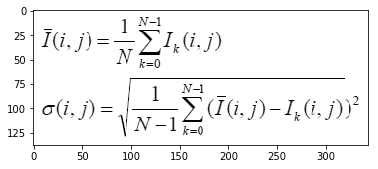

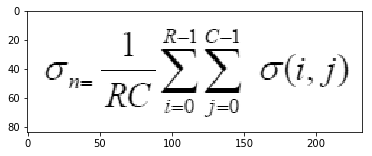

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

img = cv2.imread('for1.png', 0)
plt.imshow(img, cmap = 'gray')
plt.show()
img1 = cv2.imread('for2.png', 0)
plt.imshow(img1, cmap = 'gray')
plt.show()

In [ ]:
import os
import cv2
import numpy as np

imagesList = list() # all images read from input folder (50)
INPUT_PATH = "./images/" # input folder
OUTPUT_PATH = "./results/" # output folder

# a function to display an image to screen and save it to a file
def showImageAndSaveToFile(img,output):
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow('image', img)
    cv2.waitKey(0) and cv2.destroyAllWindows()
    cv2.imwrite(output, img)

for fileName in os.listdir(INPUT_PATH): # read all images in input folder
    imagesList.append(cv2.imread(INPUT_PATH + fileName, cv2.IMREAD_GRAYSCALE))

xSize, ySize = imagesList[0].shape # get their shape

imgSum = np.zeros((xSize, ySize), dtype=np.uint16) # temporary matrix to store the sum of various uint8 matrixes (the images)
imgAvg = np.zeros((xSize, ySize), dtype=np.uint8) # matrix of the average of all the images read

for img in imagesList:
    imgSum = np.add(imgSum, img)

imgSum = np.divide(imgSum,len(imagesList)) # get average

imgAvg = imgSum.astype(np.uint8) # convert to uint8, expected by OpenCv
            
showImageAndSaveToFile(imgAvg, OUTPUT_PATH + "imgAvg.jpeg") # show the average image

imgBuff = np.zeros((xSize, ySize), dtype=np.float64) # temporary matrix to receive the computation of average noise image
imgNes = np.zeros((xSize, ySize), dtype=np.uint8) # matrix to output the computation done in the temporary matrix

for img in imagesList: #computing average noise
    imgBuff = np.add(imgBuff,np.subtract(imgAvg, img)**2)

imgBuff = np.square(np.divide(imgBuff, len(imagesList)))

imgNes = imgBuff.astype(np.uint8) # convert to uint8, expected by OpenCv
            
showImageAndSaveToFile(imgNes, OUTPUT_PATH + "imgNoiseAvg.jpeg")  # show the average noise image

avgNoise = (np.sum(imgNes))/(xSize*ySize) # average noise escalar
print(avgNoise)